# Estimate rates: Scale-Free

In [7]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from simulate_gillespie import *
from estimate_total_rates import *

from generators_sc_test import generate_sf_sc_components
from higher_order_structures import HigherOrderStructure


from utils import save_hypergraph, load_hypergraph

## Setup

In [6]:
N = 1000
m_sc = 2
gamma_sc = 2.5
max_retries_for_stub_set = N // 100

N, sc_edges, sc_triangles, kgi_generated = generate_sf_sc_components(N, m_sc, gamma_sc, max_retries_for_stub_set)

print(f"\nSF-SC with {N} nodes.")
print(f"number of 1-simplices (edges): {len(sc_edges)}")
print(f"number of 2-simplices (triangles): {len(sc_triangles)}")


g = HigherOrderStructure(N)
all_simplices_sc = sc_edges + sc_triangles
g.set_edges(all_simplices_sc)
g.name = f"Scale-Free-SC"
g.print()

pw_degrees_sc = np.zeros(N, dtype=int)
ho_degrees_sc = np.zeros(N, dtype=int)

for i in range(N):
    pw_degrees_sc[i] = len(g.neighbors(i, 1))
    ho_degrees_sc[i] = len(g.neighbors(i, 2))

realized_avg_pw = np.mean(pw_degrees_sc)
realized_max_pw = np.max(pw_degrees_sc)

realized_avg_ho = np.mean(ho_degrees_sc)
realized_max_ho = np.max(ho_degrees_sc)

# 2nd moments (E[X^2] = Var(X) + E[X]^2) around 200?
realized_var_pw = np.var(pw_degrees_sc)
realized_var_ho = np.var(ho_degrees_sc)

realized_2nd_moment_pw = realized_var_pw + np.pow(realized_avg_pw, 2)
realized_2nd_moment_ho = realized_var_ho + np.pow(realized_avg_ho, 2)

print(f"PW:  Avg: {realized_avg_pw:.2f}, Max: {realized_max_pw:.2f}, 2nd moment: {realized_2nd_moment_pw:.2f}")
print(f"HO:  Avg: {realized_avg_ho:.2f}, Max: {realized_max_ho:.2f}, 2nd moment: {realized_2nd_moment_ho:.2f}\n")



SF-SC with 1000 nodes.
number of 1-simplices (edges): 4732
number of 2-simplices (triangles): 1624
	Scale-Free-SC on 1000 nodes with 6356 edges.

PW:  Avg: 9.46, Max: 169.00, 2nd moment: 246.74
HO:  Avg: 4.87, Max: 102.00, 2nd moment: 72.33



In [8]:
file_path = "../results/scale_free.pkl"
save_hypergraph(g, file_path)

In [10]:
pw_degrees = [len(g.neighbors(i, 1)) for i in range(g.N)]
ho_degrees = [len(g.neighbors(i, 2)) for i in range(g.N)]

print(f"{np.mean(pw_degrees):.2f}, {np.std(pw_degrees):.2f}")
print(f"{np.mean(ho_degrees):.2f}, {np.std(ho_degrees):.2f}")

print(f"{np.std(pw_degrees) / np.mean(pw_degrees):.2f}")
print(f"{np.std(ho_degrees) / np.mean(ho_degrees):.2f}")

9.46, 12.54
4.87, 6.97
1.32
1.43


In [24]:
test_name = "scale_free"

I0 = 50
nsims = 100

run_gillespie_simulations = True
time_max = 10

In [25]:
# set beta1, beta2 such that k^* = .75 N
mu    = 1             # recovery rate

# TODO: 
# Try with 
# lambda_1 \in [1, 1.3, 1.5]
# lambda_2 \in [2, 5]

lambda1 = 2.2 # <- increase lambda
lambda2 = 4.2

d1 = realized_avg_pw
d2 = realized_avg_ho

beta1 = lambda1 * mu / d1 # pairwise infection rate
beta2 = lambda2 * mu / d2 # hyperedge contagion rate

# g.summary()

print(f"{test_name}: \n")
print(f"\tH = {g.name}, N = {N}, realized (d1, d2) = ({d1:.2f}, {d2:.2f}), I0 = {I0}, time_max = {time_max},")
g.print()

print(f"\tbeta1 = {beta1:.4f}, beta2 = {beta2:.4f}")
print(f"\twith estimation based on {nsims} Gillespie simulation runs\n")

scale_free: 

	H = Scale-Free-SC, N = 1000, realized (d1, d2) = (8.88, 4.70), I0 = 50, time_max = 10,
	Scale-Free-SC on 1000 nodes with 6006 edges.

	beta1 = 0.2479, beta2 = 0.8929
	with estimation based on 100 Gillespie simulation runs



## Run Gillespie

exited on time=10.00055461407045, waiting_time=0.0007237747875823409
exited on time=10.00065350559486, waiting_time=0.0022485289539211605
exited on time=10.000790936249281, waiting_time=0.0022359674981001602
exited on time=10.000008214318285, waiting_time=0.00010719184967673661
exited on time=10.000772684780797, waiting_time=0.0007937408646726802
exited on time=10.000742264254324, waiting_time=0.0027040873036330393
exited on time=10.000312682438796, waiting_time=0.000534558837971445
exited on time=10.000201672756088, waiting_time=0.0017891778826874983
exited on time=10.000496354777317, waiting_time=0.0016775690291193767
exited on time=10.001250732375064, waiting_time=0.0019413165855559492
exited on time=10.000104417374114, waiting_time=0.0005888472176714332
exited on time=10.000009878188974, waiting_time=0.0002777364279508429
exited on time=10.001085122373729, waiting_time=0.0016353553328771287
exited on time=10.001347694549104, waiting_time=0.0015577931265890804
exited on time=10.0002

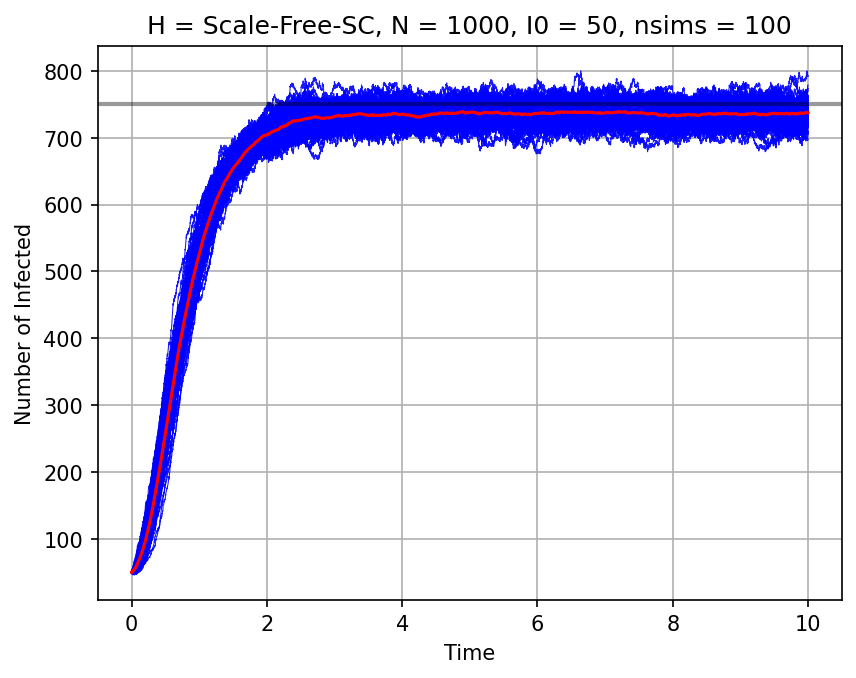

In [26]:
## --- Run Gillespie ---
run_gillespie_simulations = True

I0_gillespie = I0
nodes = list(g.nodes.keys())
initial_infections = random.sample(nodes, I0)

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}_I0={I0}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}_I0={I0}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)
plt.plot(times, avg_curve, "red")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve KEs and compare

In [27]:
target_p1 = realized_avg_pw / (N - 1.0)
target_p2 = (2.0 * realized_avg_ho) / ((N - 1.0) * (N - 2.0))

# solve KEs and compare
all_states = list(range(N + 1))
M = len(all_states)

ode_system_random = list_all_ODEs_random(g, beta1, beta2, mu, target_p1, target_p2)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

In [28]:
# solve ode_system_random over time
t_span = (0.0, time_max)

# times t_i to evaluate in, get saved in sol.t
steps_eval = 202
t_eval = np.linspace(t_span[0], t_span[1], steps_eval)

def f_ode(t, p):
    return ode_system_random(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

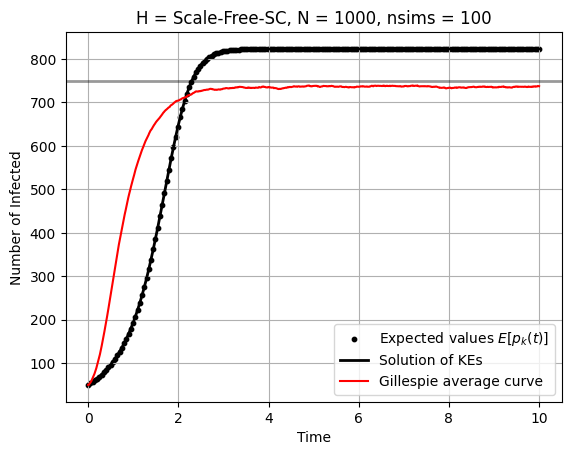

In [29]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, lw=2, color="k", label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/solution-vs-gillepsie.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Calculate the estimates

In [30]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims, N, min_Tk_threshold)

Total events processed: 1426694


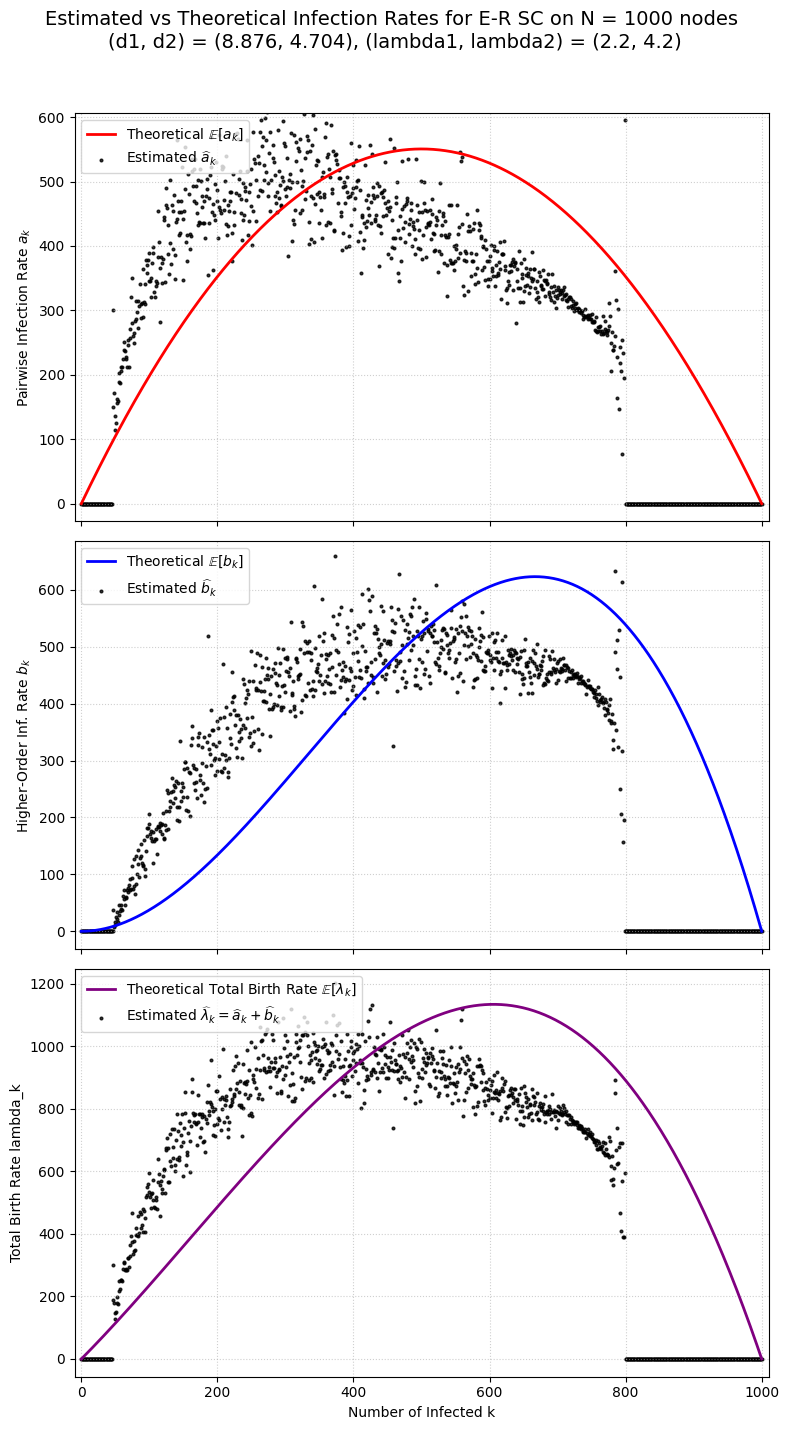

In [31]:
ak_hat_point_estimates = estimates["a_k_hat"]
bk_hat_point_estimates = estimates["b_k_hat"]
lambda_k_hat_point_estimates = estimates["lambda_k_hat"]

plot_valid_k_idx = ~np.isnan(ak_hat_point_estimates)

# theoretical (expected) rates for ER-SC
k_values = np.arange(N + 1)
k_choose_2 = np.array([comb(k, 2, exact=True) if k >= 2 else 0 for k in k_values], dtype=float)
a_k_theoretical = beta1 * target_p1 * k_values * (N - k_values)
b_k_theoretical = beta2 * target_p2 * k_choose_2 * (N - k_values)
total_birth_k_theoretical = a_k_theoretical + b_k_theoretical

fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
title = f"Estimated vs Theoretical Infection Rates for E-R SC on N = {N} nodes \n"
title += f"(d1, d2) = ({d1}, {d2}), (lambda1, lambda2) = ({lambda1}, {lambda2})"
fig.suptitle(title, fontsize=14)

# PW rates a_k
axes[0].plot(k_values, a_k_theoretical, color="red", linestyle='-', linewidth=2,
             label=r'Theoretical $\mathbb{E}[a_k]$')
axes[0].scatter(k_values[plot_valid_k_idx], ak_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{a}_k$')
axes[0].set_ylabel("Pairwise Infection Rate $a_k$")
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.6)

min_y_ak = np.nanmin(ak_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_ak_theory = np.nanmax(a_k_theoretical)
axes[0].set_ylim(bottom=min(0, min_y_ak) - 0.05 * max_y_ak_theory,
                 top=max_y_ak_theory * 1.1 if max_y_ak_theory > 0 else 0.1)


# HO rates b_k
axes[1].plot(k_values, b_k_theoretical, color="blue", linestyle='-', linewidth=2,
             label=r'Theoretical $\mathbb{E}[b_k]$')
axes[1].scatter(k_values[plot_valid_k_idx], bk_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{b}_k$')
axes[1].set_ylabel("Higher-Order Inf. Rate $b_k$")
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.6)
min_y_bk = np.nanmin(bk_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_bk_theory = np.nanmax(b_k_theoretical)
axes[1].set_ylim(bottom=min(0, min_y_bk) - 0.05 * max_y_bk_theory,
                 top=max_y_bk_theory * 1.1 if max_y_bk_theory > 0 else 0.1)


# total birth rates lambda_k = a_k + b_k
axes[2].plot(k_values, total_birth_k_theoretical, color="purple", linestyle='-', linewidth=2,
             label=r'Theoretical Total Birth Rate $\mathbb{E}[\lambda_k]$')
axes[2].scatter(k_values[plot_valid_k_idx], lambda_k_hat_point_estimates[plot_valid_k_idx],
                color="black", marker='.', s=15, alpha=0.8,
                label=r'Estimated $\widehat{\lambda}_k = \widehat{a}_k + \widehat{b}_k$')
axes[2].set_ylabel("Total Birth Rate lambda_k")
axes[2].legend(loc='upper left')
axes[2].grid(True, linestyle=':', alpha=0.6)
min_y_lk = np.nanmin(lambda_k_hat_point_estimates[plot_valid_k_idx]) if np.any(plot_valid_k_idx) else 0
max_y_lk_theory = np.nanmax(total_birth_k_theoretical)
axes[2].set_ylim(bottom=min(0, min_y_lk) - 0.05 * max_y_lk_theory,
                 top=max_y_lk_theory * 1.1 if max_y_lk_theory > 0 else 0.1)


axes[2].set_xlabel("Number of Infected k")
for ax_item in axes:
    ax_item.set_xlim(left=-N*0.01, right=N*1.01)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(f"../figures/estimation/{test_name}/supporting_fig_rates.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

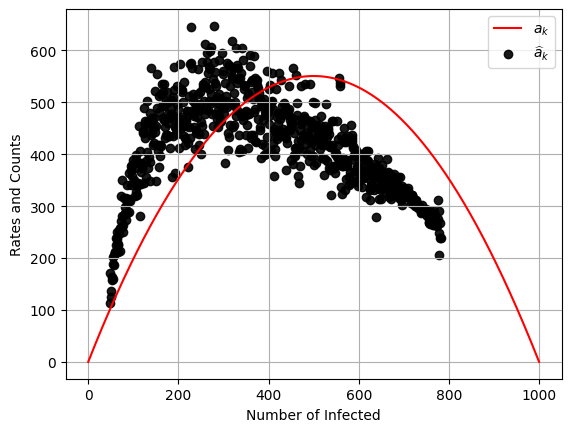

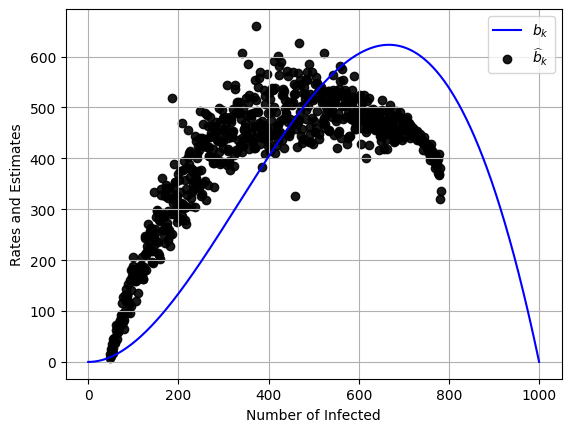

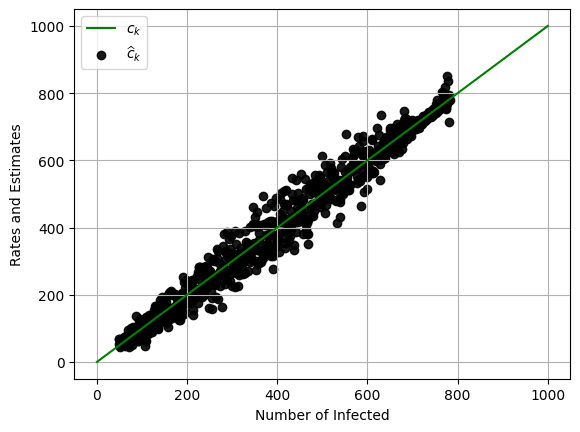

In [32]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# min_Tk_threshold = 1e-3    # TODO: tune it !
min_Tk_threshold = 0.1    # TODO: tune it !

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

# TODO: what are theoretical rates now?
a_k = target_p1 * beta1 * k_values * (N - k_values)
b_k = target_p2 * beta2 * k_choose_2 * (N - k_values)

# TODO: replace c_k with sum lambda_k = birth_rate_k = a_k + b_k
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Solve KEs using the estimates

In [33]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)


all_states = list(range(N + 1))
M = len(all_states)

p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)

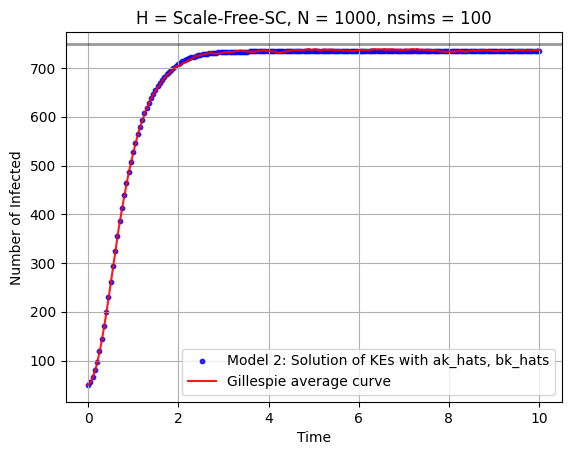

In [34]:
plt.figure()

# plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
plt.scatter(sol_hat.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.9)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/solutions-comparison.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()